# Magic sequences
[![magic_sequences.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/puzzles/magic_sequences.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/puzzles/magic_sequences.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/puzzles/magic_sequences.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/puzzles/magic_sequences.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/puzzles/magic_sequences.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/puzzles/magic_sequences.ipynb)](https://colab.ampl.com)

Description: Solving magic sequences through reinforced formulations and constrained programming. Some comparison between models and solvers is done, and we look into the "Another solution" problem for these sequences.

Tags: constraint-programming, educational, mp, sequences, arithmetic, reinforced-formulations, highs, gecode, cbc, mip

Notebook author: Marcos Dominguez Velad <<marcos@ampl.com>>

In [1]:
# Install dependencies
%pip install -q amplpy matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Description

A Magic sequence is a sequence of length $n$ is a sequence of integers $s_0 ... s_{n-1}$ such that for all $i$ in 0 to $n-1$, the number $i$ occurs exactly $s_i$ times in the sequence. For instance, 6,2,1,0,0,0,1,0,0,0 is a magic sequence since 0 occurs 6 times in it, 1 occurs twice, etc.

This problem was first proposed in CSPLib by Toby Walsh (https://www.csplib.org/Problems/prob019/), and modelled in AMPL by Hakank (check also his amazing repository of models! http://www.hakank.org/ampl/). Sequences that are self-defined are also known as "autograms".

In this notebook, we are reviewing the model for the magic sequences problem, how to enhance the model to solve larger instances. Finally, we are trying to reply computationally to the "Another Solution Problem" looking for alternatives sequences for a given length.

## Constraint Programming formulation

Writing a model with Constraint Programming is actually really neat. In ampl, we can use the `exactly` operator, that determines how many times a condition must be true.

In this case, for each $i=0 ... n-1$, we want $i$ to occur exactly $s_{i}$ times in the sequence. In ampl:

```exactly s[i] {j in 0..n-1} (s[j] = i);```


In [3]:
%%writefile seq0.mod
reset;
# number of elements
param n;

var s{0..n-1} integer >= 0 <= n-1;

subject to seq_def{i in 0..n-1}:
    exactly s[i] {j in 0..n-1} (s[j] = i);

Overwriting seq0.mod


Let's write some Python code to call a solver and find the sequence for a certain value of n. For sequences of 0 or 1 size, there is no solution.

In [4]:
def is_infeasible(ampl):
    # ampl.solve_result_num returns a value between 200-299 if the problem
    # is not feasible
    return 200 <= ampl.solve_result_num and ampl.solve_result_num <= 299


def solve_sequence(n, solver="highs"):
    ampl.param["n"] = n

    ampl.solve(solver=solver, verbose=False)

    if is_infeasible(ampl):
        return None
    else:
        return [s[1] for s in ampl.var["s"].to_list()]


ampl.read("seq0.mod")
for n in range(1, 10):
    sol = solve_sequence(n)
    if sol is None:
        print("Infeasible for n = ", n)
    else:
        print("n = " + str(n) + " ==> ", end="")
        print(*sol)

Infeasible for n =  1
Infeasible for n =  2
Infeasible for n =  3
n = 4 ==> 1 2 1 0
n = 5 ==> 2 1 2 0 0
Infeasible for n =  6
n = 7 ==> 3 2 1 1 0 0 0
n = 8 ==> 4 2 1 0 1 0 0 0
n = 9 ==> 5 2 1 0 0 1 0 0 0


## Better models

Whilst in the previous section we proposed a one-constraint formulation to solve the model, adding more constraints could be helpful in order to speedup the solving process.

Although these constraints are redundant for us, they are not for the solvers. It can be proven that given a magic sequence of n elements, there a couple properties it satisfies:

$$\sum \limits_{i = 0}^{n-1} s_i = n$$

Moreover,

$$\sum \limits_{i = 0}^{n-1} i \cdot s_i = n$$

(Remember that for we start counting from zero)

Then, we propose the reinforced formulation:

In [5]:
%%writefile seqr.mod
reset;
# number of elements
param n;

var s{0..n-1} integer >= 0 <= n-1;

subject to seq_def{i in 0..n-1}:
    exactly s[i] {j in 0..n-1} (s[j] = i);

subject to sum_of_elements:
    n = sum{i in 0..n-1} s[i];

subject to sum_of_positions:
    n = sum{i in 0..n-1} s[i]*i;

Overwriting seqr.mod


## Comparing times

There is `timeit` from python to easily compare the time between 2 functions or snippets of code. `seq0.mod` is the basic model to solve the problem. `seqr.mod` is the reinforced formulation.

In [6]:
n = 10  # run n times
ampl.read("seq0.mod")
%timeit -n 10 solve_sequence(n)

ampl.read("seqr.mod")
%timeit -n 10 solve_sequence(n)

33.5 ms ± 8.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.5 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's plot the time difference.

Testing for bigger values of `n`, it is notable how the basic model struggles, so we only run it up to `n=30` (feel free to tune and test this values).

In [7]:
import timeit

# Compute miliseconds
ampl.read("seq0.mod")
times1 = [timeit.timeit(lambda: solve_sequence(n), number=10) * 1000 for n in range(30)]
ampl.read("seqr.mod")
times2 = [
    timeit.timeit(lambda: solve_sequence(n), number=10) * 1000 for n in range(100)
]

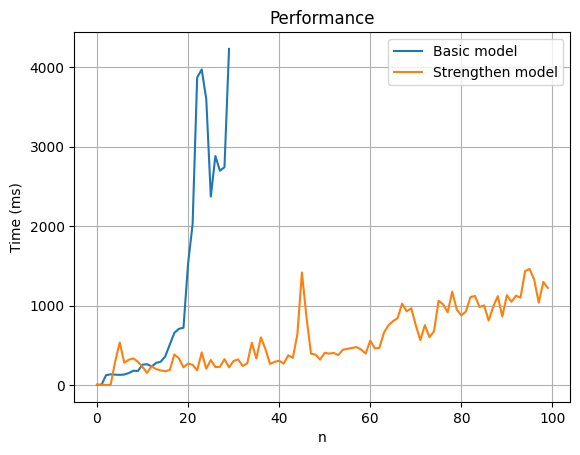

In [8]:
import matplotlib.pyplot as plt


def plot_graph_models(times1, times2):
    # Plotting the lists
    plt.plot(times1, label="Basic model")
    plt.plot(times2, label="Strengthen model")

    # Adding labels and title
    plt.xlabel("n")
    plt.ylabel("Time (ms)")
    plt.title("Performance")

    plt.grid(True)
    plt.legend()
    plt.show()


plot_graph_models(times1, times2)

## Comparing solvers performance

This is a constraint programming model, so we could expect CP specific solvers such as [gecode](https://www.gecode.org) to perform better than MIP solvers after reformulating the problem.

It is possible to use highs or cbc to solve CP problems thanks to the [MP](https://mp.ampl.com/index.html) library's reformulations.

We are only using open-source solvers for the comparison, so anybody can run and change the notebook with an ampl community license.

In [9]:
n_min = 0
n_max = 80
ampl.read("seqr.mod")
solvers = ["highs", "gecode", "cbc"]
times = {}
for solver in solvers:
    times[solver] = [
        timeit.timeit(lambda: solve_sequence(n, solver=solver), number=10) * 1000
        for n in range(n_min, n_max + 1)
    ]

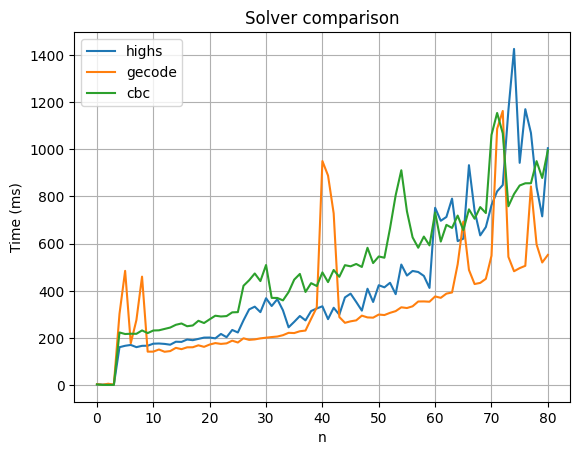

In [10]:
def plot_graph_solvers(solvers, times):
    for solver in solvers:
        plt.plot(times[solver], label=solver)

    # Adding labels and title
    plt.xlabel("n")
    plt.ylabel("Time (ms)")
    plt.title("Solver comparison")

    plt.grid(True)
    plt.legend()
    plt.show()


plot_graph_solvers(solvers, times)

As we could expect, for `n` values less than 80, the CP solver gecode performs better than highs or cbc.

## Alternative solutions?

In Computer Science, it is common to look for alternative solutions of the same problem. Given `n`, is there more than one magic sequence of `n` elements?

We should proof this formally, but software can be helpful to make an idea of the answer.

When solving the problem, we are looking for any feasible solution in the search space regardless an objective (there is no objective!). We could write an artificial objective function to navigate the search space looking for solutions following a certain pattern in order to solve the "Another solution problem".

In this case we can write a natural objective. As we have already found a solution, we can look for another one that is completely different. If $s0$ is a solution for the problem, we could search for $s$ such that:

$$\max \quad \sum \limits_{i = 0}^{n-1} |s_i-s0_i|$$
(in AMPL)
```
maximize f: sum{i in 0..n-1} abs(s[i]-s0[i]);
```

Where $|\cdot|$ is the absolute value (other vector norms could be used). The absolute value becomes linearize so MIP and CP solvers can solve the problem.

the only feasible solution with optimal value 0 is the current solucion $s0$, so another solution will give a greater optimal value.

`seq_alt.mod` contains the new model to found alternative solutions given a magic sequence.

In [11]:
%%writefile seq_alt.mod
reset;
# number of elements
param n;

var s{0..n-1} integer >= 0 <= n-1;
param s0{0..n-1};

subject to seq_def{i in 0..n-1}:
    exactly s[i] {j in 0..n-1} (s[j] = i);

subject to sum_of_elements:
    n = sum{i in 0..n-1} s[i];

subject to sum_of_positions:
    n = sum{i in 0..n-1} s[i]*i;

maximize f: sum{i in 0..n-1} abs(s[i]-s0[i]);

Overwriting seq_alt.mod


Looking for alternative solutions up to $n=25$.

In [12]:
def solve_sequence_alternative(n, solver="highs"):
    ampl.read("seqr.mod")
    sol = solve_sequence(n)
    if sol is None:
        return None

    ampl.read("seq_alt.mod")
    ampl.param["n"] = n
    # load previous solution
    ampl.param["s0"] = sol
    ampl.solve(solver=solver, verbose=False)
    if is_infeasible(ampl) or ampl.obj["f"].value() == 0:
        return None
    else:
        return [sol, [s[1] for s in ampl.var["s"].to_list()]]


for n in range(1, 25):
    sol = solve_sequence_alternative(n)
    if sol is None:
        print("No new solutions for n =", n)
    else:
        print("n = " + str(n) + " ==> ", end="")
        print(*sol[0])
        print("n = " + str(n) + " ==> ", end="")
        print(*sol[1])

No new solutions for n = 1
No new solutions for n = 2
No new solutions for n = 3
n = 4 ==> 2 0 2 0
n = 4 ==> 1 2 1 0
No new solutions for n = 5
No new solutions for n = 6
No new solutions for n = 7
No new solutions for n = 8
No new solutions for n = 9
No new solutions for n = 10
No new solutions for n = 11
No new solutions for n = 12
No new solutions for n = 13
No new solutions for n = 14
No new solutions for n = 15
No new solutions for n = 16
No new solutions for n = 17
No new solutions for n = 18
No new solutions for n = 19
No new solutions for n = 20
No new solutions for n = 21
No new solutions for n = 22
No new solutions for n = 23
No new solutions for n = 24


It seems that there is no other solution for any value of `n` (except of $n=4$).



## Exercices

1. Write a MIP formulation (without using constraint-programming) for the Magic Sequence Problem.

2. Find a formula to describe the solution for the magic sequence of $n$ elements.

3. It is possible to extend the magic sequences to an infinite number of terms. Write a model that returns the $n$ first terms of the sequence.

